##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SNGP による不確実性を考慮したディープラーニング

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/understanding/sngp">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/understanding/sngp.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/understanding/sngp.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/understanding/sngp.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

医療上の決定や自走といった安全性が非常に重要であるか、本質的にノイズの多いデータ（自然言語の理解など）が使用される AI アプリケーションでは、ディープ分類器がその不確実性を確実に定量化できることが重要です。ディープ分類器は、それ自体の制限と、人間の専門家に制御を引き渡すタイミングを認識できなければなりません。このチュートリアルでは、**Spectral-normalized Neural Gaussian Process（スペクトル正規化されたニューラルガウス過程）（[SNGP](https://arxiv.org/abs/2006.10108){.external}）**という手法を使用して、不確実性の定量化におけるディープ分類器の性能を改善する方法を説明します。

SNGP の中核にある構想は、ネットワークに単純な変更を適用することで、ディープ分類器の***距離認識***を改善することです。モデルの*距離認識*は、予測確率がテストサンプルとトレーニングデータ間の距離をどれくらい反映するかを示す尺度です。これは、絶対的基準の確率モデル（RBF カーネルを使った[ガウス過程](https://en.wikipedia.org/wiki/Gaussian_process){.external} など）に共通する望ましいプロパティではありますが、ディープニューラルネットワークを使ったモデルにはありません。SNGP は、予測精度を維持しながら、ガウス過程の動作をディープ分類器に注入する単純な方法を提供しています。

このチュートリアルでは、[scikit-learn の two moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html){.external} データセットに対してディープ残余ネットワーク（ResNet）ベースの SNGP モデルを実装し、その不確実性サーフェスと、[モンテカルロドロップアウト](https://arxiv.org/abs/1506.02142){.external}や[ディープアンサンブル](https://arxiv.org/abs/1612.01474){.external}といった他の 2 つの一般的な不確実性アプローチの不確実性サーフェスを比較します。

このチュートリアルでは、トイ 2D データセットで SNGP モデルを説明します。BERT ベースを使用して SNGP を実際の自然言語理解タスクに適用する例については、[SNGP-BERT チュートリアル](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert)をご覧ください。広範なベンチマークデータセット（[CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100)、[ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012)、[Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes) など）での SNGP モデル（およびその他多数の不確実性手法）の高品質実装については、[Uncertainty Baselines](https://github.com/google/uncertainty-baselines){.external} ベンチマークをご覧ください。

## SNGP について

SNGP は、ディープ分類器の不確実性特性を改善しながら、同等の精度とレイテンシを維持する単純なアプローチです。ディープ残余ネットワークの場合、SNGP はモデルに 2 つの単純な変更を加えます。

- スペクトル正規化を非表示残余レイヤーに適用します。
- Dense 出力レイヤーをガウス過程レイヤーに置き換えます。

> ![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


他の不確実性アプローチ（モンテカルロドロップアウトやディープアンサンブルなど）と比べ、SNGP にはいくつかのメリットがあります。

- 広範な最新鋭の残余ベースアーキテクチャ（（Wide）ResNet、DenseNet、BERT など）と機能。
- シングルモデルメソッドである（アンサンブル平均化に依存しない）。そのため、SNGP には単一の決定論的ネットワークと同程度のレイテンシがあり、[ImageNet](https://github.com/google/uncertainty-baselines/tree/main/baselines/imagenet){.external} や [Jigsaw Toxic Comments 分類](https://github.com/google/uncertainty-baselines/tree/main/baselines/toxic_comments){.external}などの大型のデータセットに簡単にスケーリングできます。
- *距離認識*プロパティにより、強力なドメイン外検出パフォーマンスを持ち合わせている。

このモデルには、以下のような欠点があります。

- SNGP の予測不確実性は、[ラプラス近似](http://www.gaussianprocess.org/gpml/chapters/RW3.pdf){.external}を使って計算される。そのため、理論的に、SNGP の事後確率の不確実性は、正確なガウス過程の不確実性と異なります。

- SNGP トレーニングには、新しいエポックの開始時に共分散のリセットステップが必要である。これにより、トレーニングパイプラインに微小な複雑性が付加される可能性があります。このチュートリアルでは、Keras コールバックを使ってこれを簡単に実装する方法を説明します。

## MNIST モデルをビルドする

In [2]:
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [3]:
# refresh pkg_resources so it takes the changes into account.
import pkg_resources
import importlib
importlib.reload(pkg_resources)

/tmpfs/tmp/ipykernel_126239/932575614.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


<module 'pkg_resources' from '/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

2024-01-11 19:21:41.327830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:21:41.327874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:21:41.329446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


可視化マクロを定義します。

In [5]:
plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## two moon データセット

[scikit-learn の two moon データセット](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html){.external}から、トレーニングデータセットと評価データセットを作成します。

In [6]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

2D 入力空間全体に対するモデルの予測動作を評価します。

In [7]:
def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

モデルの不確実性を評価するために、サードクラスに属するドメイン外（OOD）データセットを追加します。このモデルはトレーニング中にこれらの OOD サンプルを観測することはありません。

In [8]:
def make_ood_data(sample_size=500, means=(2.5, -1.75), vars=(0.01, 0.01)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

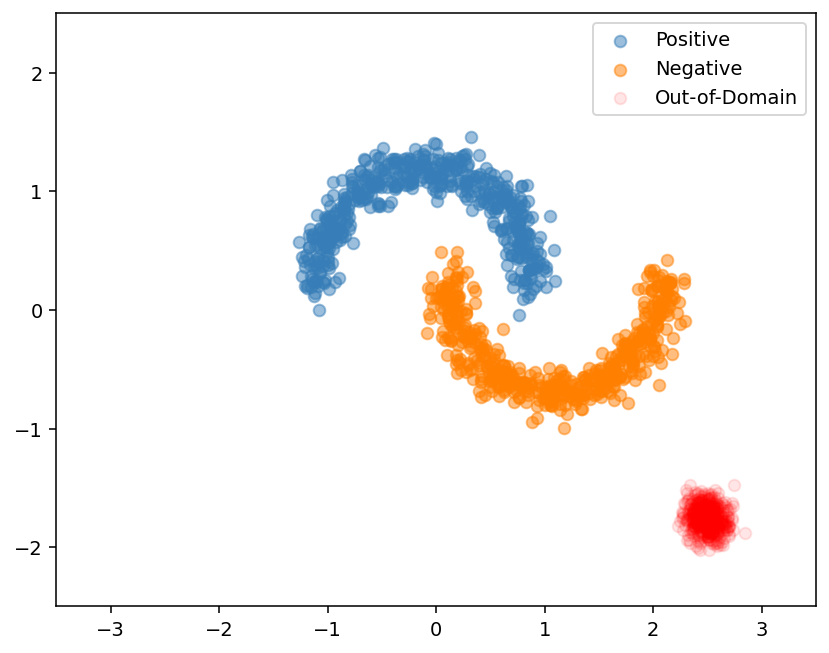

In [9]:
# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

ここでは、青とオレンジで正と負のクラスが表現されており、赤で OOD データが表されています。不確実性をうまく定量化するモデルは、トレーニングデータに近い（$p(x_{test})$ が 0 または 1 に近い）場合に信頼性があり、トレーニングデータのリージョンから遠い（$p(x_{test})$ が 0.5 に近い）場合に不確実であることが期待されます。

## 決定論的モデル

### モデルを定義する

（ベースライン）決定論的モデルから始めます。ドロップアウトの正則化を伴うマルチレイヤーの残余ネットワーク（ResNet）です。

In [10]:
#@title
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

このチュートリアルは、128 個の非表示ユニットを持つ 6 レイヤーの ResNet を使用しています。

In [11]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)

In [12]:
resnet_model = DeepResNet(**resnet_config)

In [13]:
resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               multiple                  384       


 dense_1 (Dense)             multiple                  16512     


 dense_2 (Dense)             multiple                  16512     


 dense_3 (Dense)             multiple                  16512     


 dense_4 (Dense)             multiple                  16512     


 dense_5 (Dense)             multiple                  16512     


 dense_6 (Dense)             multiple                  16512     


 dense_7 (Dense)             multiple                  258       


Total params: 99714 (389.51 KB)


Trainable params: 99330 (388.01 KB)


Non-trainable params: 384 (1.50 KB)


_________________________________________________________________


### モデルをトレーニングします。

`SparseCategoricalCrossentropy` を損失関数と Adam オプティマイザとして使用するようにトレーニングパラメータを構成します。

In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

バッチサイズを 128、エポックを 100 として、モデルをトレーニングします。

In [15]:
fit_config = dict(batch_size=128, epochs=100)

In [16]:
resnet_model.compile(**train_config)
resnet_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100


1/8 [==>...........................] - ETA: 13s - loss: 0.6234 - sparse_categorical_accuracy: 0.6562

8/8 [==============================] - 2s 4ms/step - loss: 0.4630 - sparse_categorical_accuracy: 0.7930


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3315 - sparse_categorical_accuracy: 0.8672

8/8 [==============================] - 0s 3ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9100


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1938 - sparse_categorical_accuracy: 0.9141

8/8 [==============================] - 0s 3ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9280


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1982 - sparse_categorical_accuracy: 0.9062

8/8 [==============================] - 0s 3ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.9320


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1065 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.1348 - sparse_categorical_accuracy: 0.9350


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1363 - sparse_categorical_accuracy: 0.9219

8/8 [==============================] - 0s 3ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9330


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1650 - sparse_categorical_accuracy: 0.8984

8/8 [==============================] - 0s 3ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9340


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1276 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.1148 - sparse_categorical_accuracy: 0.9380


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0780 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9400


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0914 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9460


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1414 - sparse_categorical_accuracy: 0.9141

8/8 [==============================] - 0s 3ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9480


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0570 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9480


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1397 - sparse_categorical_accuracy: 0.9062

8/8 [==============================] - 0s 3ms/step - loss: 0.1004 - sparse_categorical_accuracy: 0.9420


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1052 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.0935 - sparse_categorical_accuracy: 0.9500


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1414 - sparse_categorical_accuracy: 0.9297

8/8 [==============================] - 0s 3ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9480


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1045 - sparse_categorical_accuracy: 0.9297

8/8 [==============================] - 0s 3ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9470


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0982 - sparse_categorical_accuracy: 0.9297

8/8 [==============================] - 0s 3ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9520


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1004 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9520


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0487 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0902 - sparse_categorical_accuracy: 0.9570


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0678 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9580


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0600 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9620


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1001 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0792 - sparse_categorical_accuracy: 0.9610


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1021 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9600


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0784 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9620


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0670 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9590


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0465 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9640


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0672 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0739 - sparse_categorical_accuracy: 0.9660


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1156 - sparse_categorical_accuracy: 0.9531

8/8 [==============================] - 0s 3ms/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9630


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0690 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0791 - sparse_categorical_accuracy: 0.9660


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1065 - sparse_categorical_accuracy: 0.9297

8/8 [==============================] - 0s 3ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9730


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1342 - sparse_categorical_accuracy: 0.9375

8/8 [==============================] - 0s 3ms/step - loss: 0.0697 - sparse_categorical_accuracy: 0.9690


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0547 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9740


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1037 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0681 - sparse_categorical_accuracy: 0.9720


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1014 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0688 - sparse_categorical_accuracy: 0.9740


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0549 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9800


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0452 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9760


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0484 - sparse_categorical_accuracy: 0.9766

8/8 [==============================] - 0s 3ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9720


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0559 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9820


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0603 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0586 - sparse_categorical_accuracy: 0.9740


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0522 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9840


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0267 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0538 - sparse_categorical_accuracy: 0.9860


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0834 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9820


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0389 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0552 - sparse_categorical_accuracy: 0.9810


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1023 - sparse_categorical_accuracy: 0.9453

8/8 [==============================] - 0s 3ms/step - loss: 0.0500 - sparse_categorical_accuracy: 0.9820


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0373 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9830


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0285 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0498 - sparse_categorical_accuracy: 0.9840


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0217 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9870


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0256 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9840


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0755 - sparse_categorical_accuracy: 0.9609

8/8 [==============================] - 0s 3ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9820


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0535 - sparse_categorical_accuracy: 0.9688

8/8 [==============================] - 0s 3ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9840


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0172 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9860


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0508 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9870


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0808 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9880


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0425 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0438 - sparse_categorical_accuracy: 0.9870


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0196 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9900


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0266 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0404 - sparse_categorical_accuracy: 0.9870


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0642 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9900


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0391 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0401 - sparse_categorical_accuracy: 0.9890


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0241 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9870


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0187 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9930


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0443 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9900


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0104 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9930


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0403 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9890


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0525 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9920


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0461 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9900


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0268 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9920


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0150 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9890


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0596 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0276 - sparse_categorical_accuracy: 0.9920


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9910


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0203 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0237 - sparse_categorical_accuracy: 0.9920


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0321 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0314 - sparse_categorical_accuracy: 0.9910


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0168 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9920


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0142 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9940


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0198 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9910


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0120 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0249 - sparse_categorical_accuracy: 0.9930


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0169 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9920


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0227 - sparse_categorical_accuracy: 0.9940


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0422 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9930


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9910


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0158 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0204 - sparse_categorical_accuracy: 0.9930


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0489 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9930


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0374 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0214 - sparse_categorical_accuracy: 0.9940


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0188 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0235 - sparse_categorical_accuracy: 0.9920


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0224 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0225 - sparse_categorical_accuracy: 0.9940


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0650 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9950


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0056 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9950


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0192 - sparse_categorical_accuracy: 0.9940


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9940


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0519 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9950


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0054 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9930


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0093 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9970


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9940


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0280 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 3ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9930


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0097 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 3ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9930


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0084 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9930


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0024 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9960


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0044 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9930


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0080 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0171 - sparse_categorical_accuracy: 0.9950


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0071 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9960


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0023 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 3ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9950


### 不確実性を可視化する

In [17]:
#@title
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.
  
  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).
  
  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

次に、決定論的モデルの予測を可視化します。まず、クラスの確率をプロットします: $$p(x) = softmax(logit(x))$$

In [18]:
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

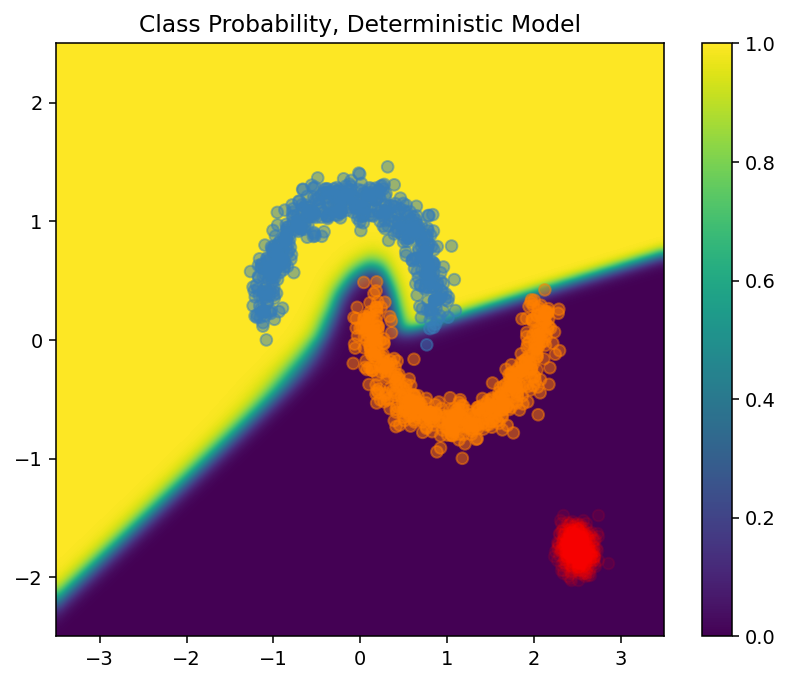

In [19]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_probs, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Class Probability, Deterministic Model")

plt.show()

このプロットでは、黄色と紫で 2 つのクラスの予測確率が表現されています。この決定論的モデルは、非線形決定境界で、2 つの既知のクラス（青とオレンジ）をうまく分類していますが、**距離認識**ではなく、観測されていない赤のドメイン外（OOD）サンプルを確信的にオレンジクラスとして分類しています。

[予測分散](https://en.wikipedia.org/wiki/Bernoulli_distribution#Variance)を計算して、モデルの不確実性を可視化します: $$var(x) = p(x) * (1 - p(x))$$

In [20]:
resnet_uncertainty = resnet_probs * (1 - resnet_probs)

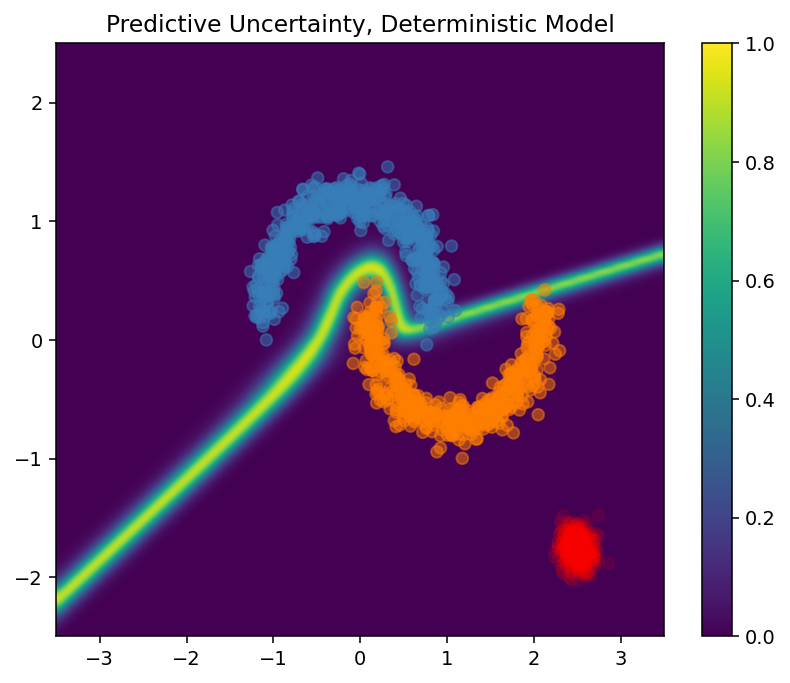

In [21]:
_, ax = plt.subplots(figsize=(7, 5.5))

pcm = plot_uncertainty_surface(resnet_uncertainty, ax=ax)

plt.colorbar(pcm, ax=ax)
plt.title("Predictive Uncertainty, Deterministic Model")

plt.show()

このプロットでは、黄色で高い不確実性を示し、紫で低い不確実性を示しています。決定論的 ResNet の不確実性は、テストサンプルの決定境界からの距離のみに依存しています。このため、トレーニングドメイン外になると、モデルの過学習が発生しています。次のセクションでは、SNGP がこのデータセットでどのように動作するかを説明します。

## SNGP モデル

### SNGP モデルを定義する

SNGP モデルを実装しましょう。`SpectralNormalization` と `RandomFeatureGaussianProcess` のいずれの SNGP コンポーネントも、tensorflow_model の[組み込みレイヤー](https://github.com/tensorflow/models/tree/master/official/nlp/modeling/layers)で使用できます。 

> ![SNGP](http://tensorflow.org/tutorials/understanding/images/sngp.png)


次に、これらの 2 つのコンポーネントをさらに詳しく調べましょう。（[完全な SNGP モデル](#full-sngp-model)のセクションでも、SNGP がどのように実装されているかについて知ることができます。）

#### `SpectralNormalization` ラッパー

[`SpectralNormalization`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/spectral_normalization.py){.external} は Keras レイヤーラッパーです。以下のようにして既存の Dense レイヤーに適用できます。

In [22]:
dense = tf.keras.layers.Dense(units=10)
dense = nlp_layers.SpectralNormalization(dense, norm_multiplier=0.9)

スペクトル正規化は、そのスペクトル基準（$W$ の最大固有値）を徐々にターゲット値の `norm_multiplier` に誘導することで、非表示の重み $W$ を正則化します。


注意: 通常、`norm_multiplier` を 1 より小さい値に設定することが推奨されます。ただし、実際には、ディープネットワークに十分な表現力を持たせるために、より大きな値に緩和することもできます。

#### ガウス過程（GP）レイヤー

[`RandomFeatureGaussianProcess`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/gaussian_process.py){.external} は、[ランダム特徴量ベースの近似](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf){.external}を、ディープニューラルネットワークでエンドツーエンドのトレーニング可能なガウス過程モデルに実装します。内部的には、ガウス過程レイヤーは以下の 2 層ネットワークを実装します。

```
$$logits(x) = \Phi(x) \beta, \quad \Phi(x)=\sqrt{\frac{2}{M}} * cos(Wx + b)$$
```

ここで、$x$ は入力で、$W$ と $b$ はそれぞれガウスと一様分布からランダムに初期化される凍結された重みです。（そのため、$\Phi(x)$ は「ランダム特徴量」と呼ばれます。）$\beta$ は Dense レイヤーに似た学習可能なカーネルの重みです。 

In [23]:
batch_size = 32
input_dim = 1024
num_classes = 10

In [24]:
gp_layer = nlp_layers.RandomFeatureGaussianProcess(units=num_classes,
                                               num_inducing=1024,
                                               normalize_input=False,
                                               scale_random_features=True,
                                               gp_cov_momentum=-1)

以下は、GP レイヤーの主なパラメーターです。

- `units`: 出力ロジットの次元
- `num_inducing`: 非表示の重み $W$ の次元 $M$。デフォルトは 1024 です。
- `normalize_input`: レイヤーの正規化を入力 $x$ に適用するかどうか。
- `scale_random_features`: スケール $\sqrt{2/M}$ を非表示の出力に適用するかどうか。


注意: 学習率に敏感なディープニューラルネットワーク（ResNet-50 や ResNet-110 など）の場合は、一般的に、トレーニングを安定化するには `normalize_input=True` に設定し、GP レイヤーを通過する際に期待されない方法で学習率が変更されないようにするには `scale_random_features=False` に設定することが推奨されます。

- `gp_cov_momentum` は、モデル共分散が計算される方法を制御します。正の値（`0.999` など）に設定された場合、共分散行列は運動量ベースの移動平均の更新を使って計算されます。`-1` に設定された場合、共分散行列は運動量無しで更新されます。

注意: 運動量ベースの移動平均の更新方法は、バッチサイズに敏感な場合があります。そのため、一般的に、`gp_cov_momentum=-1` に設定して、共分散を正確に計算することが推奨されます。これが正しく動作するには、同じデータが 2 回カウントされないようにするために、共分散行列の Estimator を新しいエポックの開始時にリセットする必要があります。`RandomFeatureGaussianProcess` の場合、これは、`reset_covariance_matrix()` を呼び出して行えます。次のセクションでは、Keras の組み込み API を使ってこれを簡単に実装する方法を説明します。


形状 `(batch_size, input_dim)` のバッチ入力がある場合、GP レイヤーは予想に `logits` テンソル（形状 `(batch_size, num_classes)`）だけでなく、バッチロジットの事後確率共分散行列である `covmat` テンソル（形状 `(batch_size, batch_size)`）も返します。

In [25]:
embedding = tf.random.normal(shape=(batch_size, input_dim))

logits, covmat = gp_layer(embedding)

注意: この SNGP モデルの実装では、全クラスの予測ロジット $logit(x_{test})$ が同じ共分散行列を共有していることに注目してください。これは、トレーニングデータからの $x_{test}$ 間の距離を示しています。

理論的に言えば、異なるクラスに対する異なるバリアンスの値を計算するようにアルゴリズムを拡張することが可能ですが（[SNGP 論文の原文を参照](https://arxiv.org/abs/2006.10108){.external}）、これを、大規模な出力空間を伴う問題（ImageNet または言語モデリングによる分類など）にスケーリングすることは困難です。

<a name="full-sngp-model"></a>

#### 完全な SNGP モデル

基底クラスの `DeepResNet` がある場合、SNGP モデルは、残余ネットワークの非表示レイヤーと出力レイヤーを変更することで簡単に実装できます。Keras `model.fit()` API との互換性を得るために、モデルの `call()` メソッドも変更して、トレーニング中にのみ `logits` を出力するようにします。

In [26]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

決定論的モデルと同じアーキテクチャを使用します。

In [27]:
resnet_config

{'num_classes': 2, 'num_layers': 6, 'num_hidden': 128}

In [28]:
sngp_model = DeepResNetSNGP(**resnet_config)

In [29]:
sngp_model.build((None, 2))
sngp_model.summary()

Model: "deep_res_net_sngp"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense_9 (Dense)             multiple                  384       


 spectral_normalization_1 (  multiple                  16768     


 SpectralNormalization)                                          


 spectral_normalization_2 (  multiple                  16768     


 SpectralNormalization)                                          


 spectral_normalization_3 (  multiple                  16768     


 SpectralNormalization)                                          


 spectral_normalization_4 (  multiple                  16768     


 SpectralNormalization)                                          


 spectral_normalization_5 (  multiple                  16768     


 SpectralNormalization)                                          


 spectral_normalization_6 (  multiple                  16768     


 SpectralNormalization)                                          


 random_feature_gaussian_pr  multiple                  1182722   


 ocess (RandomFeatureGaussi                                      


 anProcess)                                                      


Total params: 1283714 (4.90 MB)


Trainable params: 101120 (395.00 KB)


Non-trainable params: 1182594 (4.51 MB)


_________________________________________________________________


<a name="covariance-reset-callback"></a> 新しいエポックの開始時に共分散行列をリセットする Keras コールバックを実装します。

In [30]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

このコールバックを `DeepResNetSNGP` モデルクラスに追加します。

In [31]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

### モデルをトレーニングします。

`tf.keras.model.fit` を使用してモデルをトレーニングします。

In [32]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(train_examples, train_labels, **fit_config)

Epoch 1/100


1/8 [==>...........................] - ETA: 11s - loss: 0.6944 - sparse_categorical_accuracy: 0.9362

8/8 [==============================] - 2s 5ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.9260


Epoch 2/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5839 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.5485 - sparse_categorical_accuracy: 0.9930


Epoch 3/100


1/8 [==>...........................] - ETA: 0s - loss: 0.5142 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 5ms/step - loss: 0.4944 - sparse_categorical_accuracy: 0.9970


Epoch 4/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4692 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.4518 - sparse_categorical_accuracy: 0.9970


Epoch 5/100


1/8 [==>...........................] - ETA: 0s - loss: 0.4357 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.4161 - sparse_categorical_accuracy: 0.9980


Epoch 6/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3957 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.9970


Epoch 7/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3629 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.9950


Epoch 8/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3472 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.3423 - sparse_categorical_accuracy: 0.9960


Epoch 9/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3395 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.3244 - sparse_categorical_accuracy: 0.9960


Epoch 10/100


1/8 [==>...........................] - ETA: 0s - loss: 0.3076 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.3066 - sparse_categorical_accuracy: 0.9960


Epoch 11/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2992 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2909 - sparse_categorical_accuracy: 0.9960


Epoch 12/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2901 - sparse_categorical_accuracy: 0.9844

8/8 [==============================] - 0s 5ms/step - loss: 0.2783 - sparse_categorical_accuracy: 0.9960


Epoch 13/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2640 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.2656 - sparse_categorical_accuracy: 0.9970


Epoch 14/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2586 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2520 - sparse_categorical_accuracy: 0.9960


Epoch 15/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2405 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9960


Epoch 16/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2301 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.2321 - sparse_categorical_accuracy: 0.9970


Epoch 17/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2351 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.2235 - sparse_categorical_accuracy: 0.9960


Epoch 18/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2208 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.2146 - sparse_categorical_accuracy: 0.9970


Epoch 19/100


1/8 [==>...........................] - ETA: 0s - loss: 0.2044 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9970


Epoch 20/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1967 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1994 - sparse_categorical_accuracy: 0.9970


Epoch 21/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1954 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9970


Epoch 22/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1891 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9970


Epoch 23/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1812 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1803 - sparse_categorical_accuracy: 0.9980


Epoch 24/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1757 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.9970


Epoch 25/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1620 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.9990


Epoch 26/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1604 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9980


Epoch 27/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1645 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1587 - sparse_categorical_accuracy: 0.9970


Epoch 28/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1533 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9970


Epoch 29/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1574 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9990


Epoch 30/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1398 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1448 - sparse_categorical_accuracy: 0.9990


Epoch 31/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1451 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1408 - sparse_categorical_accuracy: 0.9980


Epoch 32/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1432 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.1379 - sparse_categorical_accuracy: 0.9990


Epoch 33/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1301 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1331 - sparse_categorical_accuracy: 0.9990


Epoch 34/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1291 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9980


Epoch 35/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1417 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.9990


Epoch 36/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1239 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1235 - sparse_categorical_accuracy: 0.9980


Epoch 37/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1117 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9980


Epoch 38/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1144 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9980


Epoch 39/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1151 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1145 - sparse_categorical_accuracy: 0.9990


Epoch 40/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1081 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1114 - sparse_categorical_accuracy: 0.9980


Epoch 41/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1078 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.1089 - sparse_categorical_accuracy: 0.9990


Epoch 42/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1055 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1049 - sparse_categorical_accuracy: 0.9990


Epoch 43/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1071 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.1031 - sparse_categorical_accuracy: 0.9990


Epoch 44/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0951 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9990


Epoch 45/100


1/8 [==>...........................] - ETA: 0s - loss: 0.1058 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 4ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9990


Epoch 46/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0943 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9990


Epoch 47/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0892 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0945 - sparse_categorical_accuracy: 0.9990


Epoch 48/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0950 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9990


Epoch 49/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0962 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 4ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9990


Epoch 50/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0877 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9990


Epoch 51/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0927 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0860 - sparse_categorical_accuracy: 0.9990


Epoch 52/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0896 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9990


Epoch 53/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0921 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0829 - sparse_categorical_accuracy: 0.9990


Epoch 54/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0811 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9990


Epoch 55/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0744 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0797 - sparse_categorical_accuracy: 0.9990


Epoch 56/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0825 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9980


Epoch 57/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0836 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9990


Epoch 58/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0697 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9990


Epoch 59/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0792 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9990


Epoch 60/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0692 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0722 - sparse_categorical_accuracy: 0.9990


Epoch 61/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0705 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0701 - sparse_categorical_accuracy: 0.9990


Epoch 62/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0649 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0696 - sparse_categorical_accuracy: 0.9990


Epoch 63/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0708 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0680 - sparse_categorical_accuracy: 0.9990


Epoch 64/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0715 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9990


Epoch 65/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0651 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9990


Epoch 66/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0593 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0645 - sparse_categorical_accuracy: 0.9990


Epoch 67/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0606 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9990


Epoch 68/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0646 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9990


Epoch 69/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0606 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9990


Epoch 70/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0581 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9990


Epoch 71/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0595 - sparse_categorical_accuracy: 0.9990


Epoch 72/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0577 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9990


Epoch 73/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0580 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0567 - sparse_categorical_accuracy: 0.9990


Epoch 74/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0528 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9990


Epoch 75/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0565 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0554 - sparse_categorical_accuracy: 0.9990


Epoch 76/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0583 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9990


Epoch 77/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0561 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9990


Epoch 78/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0527 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9990


Epoch 79/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0545 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9990


Epoch 80/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0604 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9990


Epoch 81/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0484 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0490 - sparse_categorical_accuracy: 1.0000


Epoch 82/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0470 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0487 - sparse_categorical_accuracy: 0.9990


Epoch 83/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0467 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9990


Epoch 84/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0514 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0474 - sparse_categorical_accuracy: 1.0000


Epoch 85/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0514 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9990


Epoch 86/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0449 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0458 - sparse_categorical_accuracy: 0.9990


Epoch 87/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0438 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0450 - sparse_categorical_accuracy: 1.0000


Epoch 88/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0441 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0445 - sparse_categorical_accuracy: 1.0000


Epoch 89/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0486 - sparse_categorical_accuracy: 0.9922

8/8 [==============================] - 0s 5ms/step - loss: 0.0440 - sparse_categorical_accuracy: 0.9990


Epoch 90/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0430 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0441 - sparse_categorical_accuracy: 0.9990


Epoch 91/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0447 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9990


Epoch 92/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0430 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0417 - sparse_categorical_accuracy: 1.0000


Epoch 93/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0427 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0411 - sparse_categorical_accuracy: 0.9990


Epoch 94/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0447 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0408 - sparse_categorical_accuracy: 1.0000


Epoch 95/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0403 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9990


Epoch 96/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0376 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0385 - sparse_categorical_accuracy: 1.0000


Epoch 97/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0410 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9990


Epoch 98/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0376 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0385 - sparse_categorical_accuracy: 1.0000


Epoch 99/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0428 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0383 - sparse_categorical_accuracy: 1.0000


Epoch 100/100


1/8 [==>...........................] - ETA: 0s - loss: 0.0349 - sparse_categorical_accuracy: 1.0000

8/8 [==============================] - 0s 5ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9990


### 不確実性を可視化する

まず、予測ロジットとバリアンスを計算します。

In [33]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)

In [34]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

<a name="mean-field-logits"></a> 次に、事後予測確率を計算します。確率モデルの予測確率を計算するには、以下のモンテカルロサンプリングを使用するのが古典的です。

```
$$E(p(x)) = \frac{1}{M} \sum_{m=1}^M logit_m(x), $$
```

ここで、$M$ はサンプルサイズで、$logit_m(x)$ は、SNGP 事後確率 $MultivariateNormal$(`sngp_logits`,`sngp_covmat`) からのランダムサンプルです。ただし、このアプローチでは、自走車両やリアルタイム入札といった遅延に敏感なアプリケーションでは遅くなる可能性があります。代わりに、[平均場法](https://arxiv.org/abs/2006.07584){.external} を使用して、$E(p(x))$ を概算することができます。

```
$$E(p(x)) \approx softmax(\frac{logit(x)}{\sqrt{1+ \lambda * \sigma^2(x)}})$$
```

ここで、$\sigma^2(x)$ は SNGP バリアンスで、$\lambda$ は$\pi/8$ または $3/\pi^2$ として選択されることがよくあります。

In [35]:
sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]

注意: $\lambda$ を固定値に設定する代わりに、それをハイパーパラメータとして扱い、モデルの較正パフォーマンスを最適化するように調整することもできます。これは、ディープラーニングの不確実性に関する文献では、[温度スケーリング](http://proceedings.mlr.press/v70/guo17a.html){.external}として知られています。 

この平均場法は、組み込み関数の `layers.gaussian_process.mean_field_logits` として実装されます。

In [36]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)
  
  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [37]:
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

### SNGP のまとめ

In [38]:
#@title

def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()  

これで、すべてを一まとめにできるようになりました。トレーニング、評価、および不確実性の計算という手続き全体を、わずか 5 行で完了することができます。

In [39]:
def train_and_test_sngp(train_examples, test_examples):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [40]:
sngp_probs = train_and_test_sngp(train_examples, test_examples)

SNGP モデルのクラス確率（左）と予測不確実性（右）を可視化します。

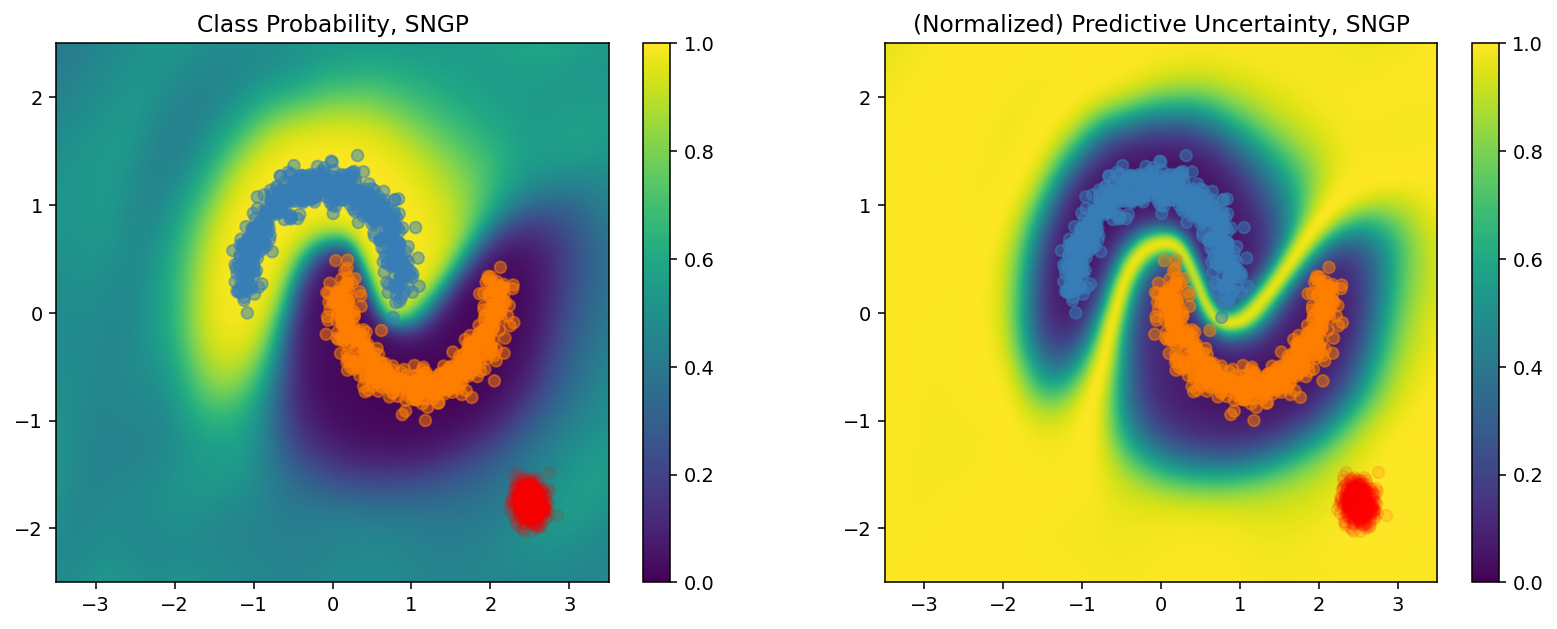

In [41]:
plot_predictions(sngp_probs, model_name="SNGP")

クラス確率プロット（左）では、黄色と紫がクラス確率であることを思い出しましょう。トレーニングデータのドメインに近づくと、SNGP はサンプルを高い信頼で正しく分類します（0 または 1 に近い確率を割り当てます）。トレーニングデータから遠い場合、SNGP の信頼は徐々に低くなり、予測確率が 0.5 に近づく一方で、（正規化された）モデル不確実性が 1 に上昇します。

これを、決定論的モデルの不確実性サーフェスと比較します。 

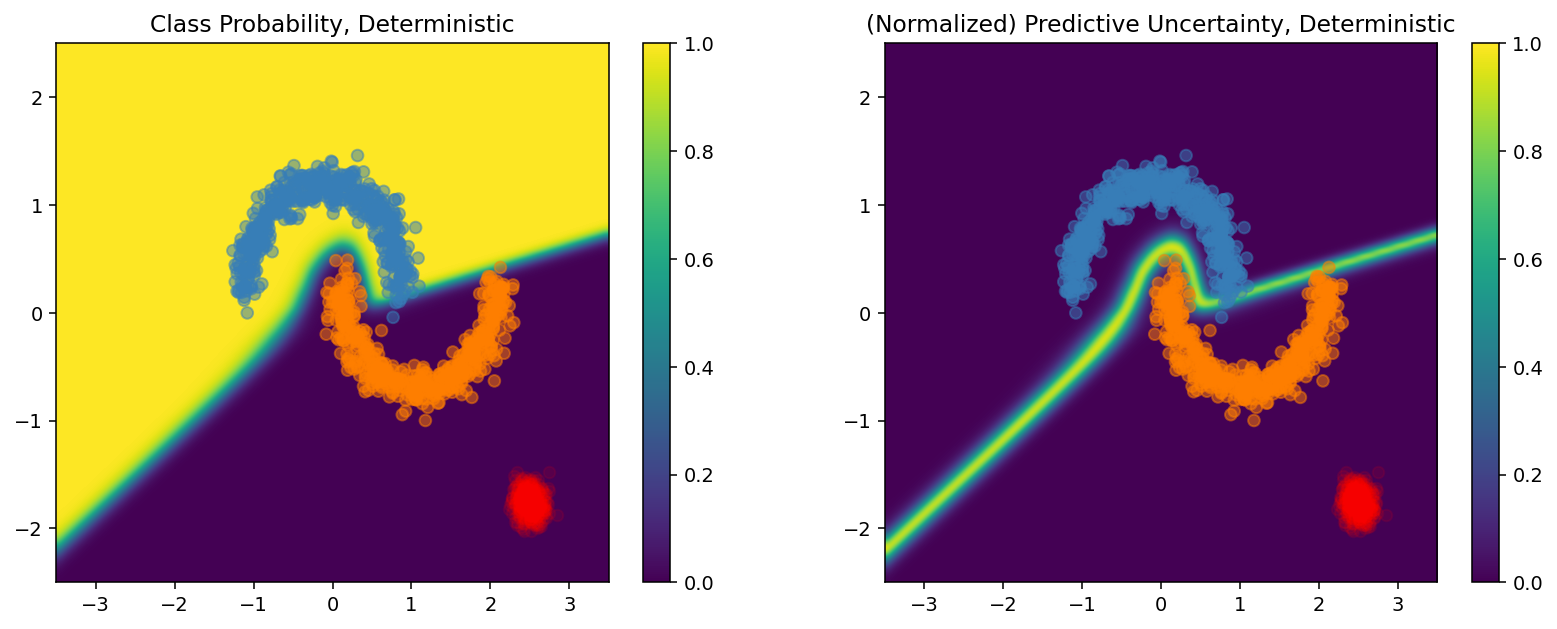

In [42]:
plot_predictions(resnet_probs, model_name="Deterministic")

前述のとおり、決定論的モデルは*距離認識*ではありません。その不確実性は、決定境界からのテストサンプルの距離で定義されています。このため、モデルはドメイン外サンプル（赤）の過信予測を生成してしまいます。

## 他の不確実性アプローチとの比較

このセクションでは、SNGP の不確実性を[モンテカルロドロップアウト](https://arxiv.org/abs/1506.02142){.external}と[ディープアンサンブル](https://arxiv.org/abs/1612.01474){.external}と比較します。

これらのいずれの手法も、決定論的モデルの複数フォワードパスのモンテカルロアベレージングに基づきます。まず、アンサンブルサイズ $M$ を設定します。

In [43]:
num_ensemble = 10

### モンテカルロドロップアウト

ドロップアウトレイヤーを持つトレーニング済みのネットワークがある場合、モンテカルロドロップアウトは、以下の平均予測確率

```
$$E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$$
```

を、複数のドロップアウト有効フォワードパス ${logit_m(x)}_{m=1}^M$ で平均化して計算します。

In [44]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [45]:
# Monte Carlo dropout inference.
dropout_logit_samples = [mc_dropout_sampling(test_examples) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [46]:
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

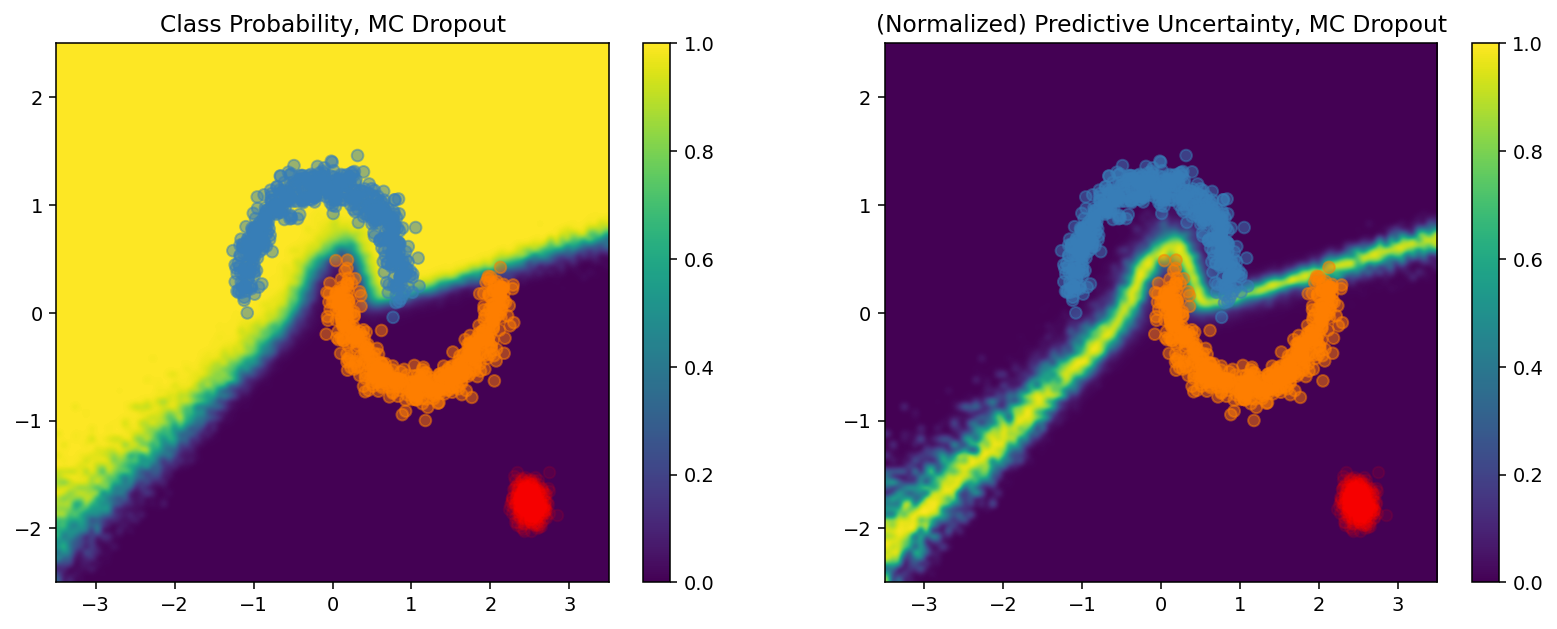

In [47]:
plot_predictions(dropout_probs, model_name="MC Dropout")

### ディープアンサンブル

ディープアンサンブルは、ディープラーニング不確実性の最新の（ただし高価な）手法です。ディープアンサンブルをトレーニングするには、まず、$M$ 個のアンサンブルメンバーをトレーニングする必要があります。

In [48]:
# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(train_examples, train_labels, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

ロジットを収集し、平均予測確率 $E(p(x)) = \frac{1}{M}\sum_{m=1}^M softmax(logit_m(x))$ を計算します。

In [49]:
# Deep ensemble inference
ensemble_logit_samples = [model(test_examples) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

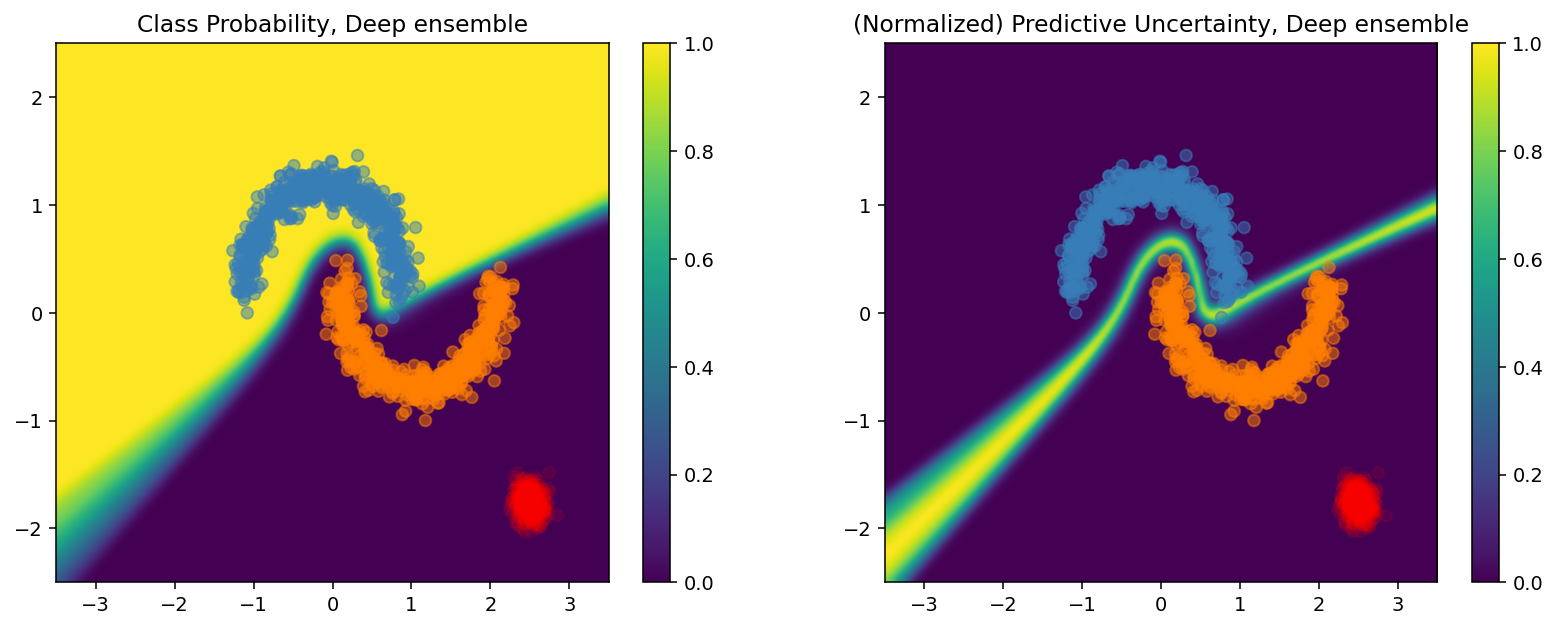

In [50]:
plot_predictions(ensemble_probs, model_name="Deep ensemble")

モンテカルロドロップアウトとディープアンサンブルのいずれの手法も、決定境界の確実性を抑えることで、モデルの不確実性の能力を改善しています。ただし、いずれも、距離認識が欠けているという、決定論的ディープネットワークの制約を継承しています。

## まとめ

このチュートリアルでは、以下のことを行いました。

- ディープ分類器に SNGP モデルを実装し、距離認識を改善しました。
- Keras `Model.fit` API を使用して、SNGP モデルをエンドツーエンドでトレーニングしました。
- SNGP の不確実性の動作を可視化しました。
- SNGP、モンテカルロドロップアウト、およびディープアンサンブルのモデルで不確実性の動作を比較しました。

## リソースとその他の文献

- 不確実性を認識する自然言語の理解に関する BERT モデルに SNGP を適用する例については、[SNGP-BERT チュートリアル](https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert)をご覧ください。
- 広範なベンチマークデータセット（[CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100)、[ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012)、[Jigsaw 毒性検出](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes)など）での SNGP モデルの実装については、[Uncertainty Baselines GitHub リポジトリ](https://github.com/google/uncertainty-baselines){.external}にアクセスしてください。
- SNGP をさらに理解するには、『[Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108){.external}』という論文をご覧ください。
